## Data Generation
In this notebook we simulate satellite reads (sBCs) for beads arranged uniformly in a grid as well as for positions for kidney and cerebellum tissue samples from the Slide-seq dataset [Rodriques et al., 2019](https://www.science.org/doi/10.1126/science.aaw1219).

In [1]:
import numpy as np
import pandas as pd
import anndata
import math
from matplotlib import pyplot as plt

import sys
sys.path.append("../functions/")
import simulate_barcodes as simulate
import simulate_barcodes_bacterial as simulate_bacterial
import utils

First we define the parameters for the simulations. For all simulations, we need to define the satellite density, the width of the diffusion kernel, and the sample we want to use for our experimental reads per bead simulation, which determines the sequencing depth. For the uniform grid, we also define the area size. By default, we use the distribution from the Slide-seq kidney dataset with a median of 140 reads or 80 UMI per bead. The experimental distribution of reads per bead is used to simulate the variation of bead qualities  encountered in practice. The satellite barcodes are also generated based on an experimental distribution, as we observed that the 65,000 8-base barcodes do not occur uniformly in practice.

The default parameters can be changed to simulate different sized areas, satellite densities, diffusion constants, or sequencing depths. A variety of bead read distributions for both the kidney are cerebellum tissues are available in the data/bead-read-distribution folder. 

In [2]:
# Define parameters for the run
SEED = 42
RNG = np.random.default_rng(SEED)
NUM_PROC = 32

SATELLITES_PER_CM2 = 10**5
SIGMA_UM = 50 # Width of the Gaussian kernel representing satellite diffusion in micro-meters
SAMPLE = 'kidney_140rpb' # Sample to use for the bead-read distribution

BEADS_PER_CM2 = 10**6
AREA_CM2 = 0.1

BEADS = int(BEADS_PER_CM2 * AREA_CM2)
SATELLITES = int(SATELLITES_PER_CM2 * AREA_CM2)
n = np.floor(np.sqrt(BEADS))

BEADWIDTH = 10 # Beadwidth in um
SIGMA = SIGMA_UM/(n*BEADWIDTH) # Sigma in normalized coordinates
SIGMA_BEAD = int(SIGMA_UM / BEADWIDTH) # Sigma in beadwidths

# Factor by which satellites should extended past beads, this reduces edge effects from beads along the
# edge getting fewer reads
SIGMA_BUFFER = 2

In [3]:
# Load the bead-quality and barcode overlap distributions
reads_dist = pd.read_csv('../data/bead-quality-distributions/{}.csv'.format(SAMPLE), index_col=0)
overlap_dist = pd.read_csv('../data/barcode-distribution.csv', index_col=0)

### Uniform Grid
First, we simulate data on a 0.1 square centimeter dense, uniform grid of 10 micro-meter beads.

In [4]:
# Generate random satellites on a unit square and beads on a grid
y, x = np.meshgrid(np.arange(0,n), np.arange(0,n))
y = y.flatten()
x = x.flatten()
bead_coords = np.array([x/max(x), y/max(y)]).T
satellite_coords = RNG.random((int((SATELLITES)*((1+2*SIGMA_BUFFER*SIGMA)**2)), 2))*(1 + 2*SIGMA_BUFFER*SIGMA) - SIGMA_BUFFER*SIGMA

beads_df = pd.DataFrame(data=bead_coords, columns=['x', 'y'])
satellites_df = pd.DataFrame(data=satellite_coords, columns=['x', 'y'])

In [5]:
# Generate an anndata with satellite barcode counts stored in the read matrix
adata = simulate.generate_reads(SIGMA, bead_coords, satellite_coords,
                                num_proc=NUM_PROC, overlap_dist=overlap_dist['Dist'],
                                reads_dist=reads_dist, scaling=False)

adata.write_h5ad('../data/adata/{}_satellites={}_sigma={}.h5ad'.format(SAMPLE, SATELLITES_PER_CM2, SIGMA_UM))

100%|██████████| 99856/99856 [00:11<00:00, 8408.99it/s]


Matrix build time: 12.607421875


/mnt/geofflab/jupyterhub/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
... storing 'spatial_color' as categorical


Next we visualize the simulated data, showing reads from individual colonies. Note that due to the distribution of bead qualities, adjacent beads may differ significantly in the number of reads from the same colony. However the proportion of reads from each nearby colony remains similar, allowing us to reconstruct their positions.

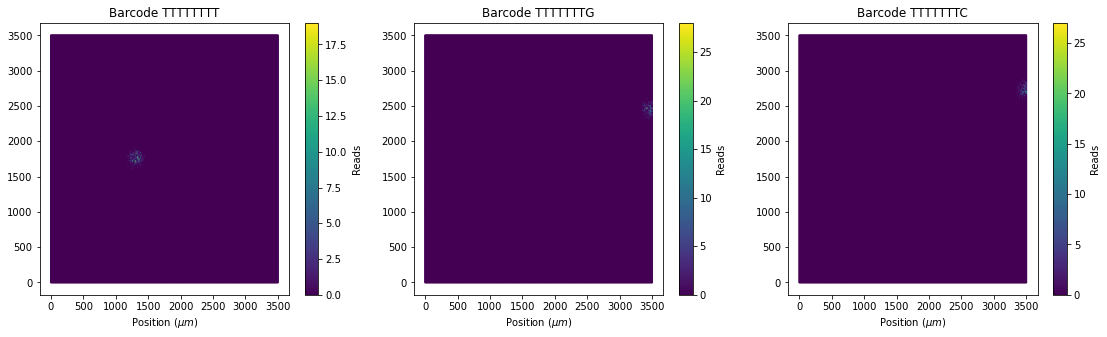

In [6]:
# Visualize reads from a few satellites
EDGE_LENGTH_UM = int(10*n)
STEP_UM = 500
steps = int(np.ceil(EDGE_LENGTH_UM/STEP_UM))

fig = plt.figure(figsize=(19,5))
for i in range(3):
    plt.subplot(1,3,i + 1)
    plt.title('Barcode {}'.format(overlap_dist.index[i]))
    plt.scatter(adata.obs.x, adata.obs.y, c=adata.X.A[:,i], s=1)
    plt.colorbar(label='Reads')
    plt.xticks(np.arange(0, (steps + 1)/steps, 1/steps), range(0, STEP_UM*steps + 1, STEP_UM))
    plt.yticks(np.arange(0, (steps + 1)/steps, 1/steps), range(0, STEP_UM*steps + 1, STEP_UM))
    plt.xlabel('Position ($\mu m$)')
plt.show()

### Slide-seq Kidney Positions

Here we repeat the data generation process using ground-truth positions from the kidney sample in the Slide-seq dataset.

In [7]:
# Generate the dataframes of bead and satellite positions
kidney = pd.read_csv('../data/slideseq-positions/kidney_positions.csv', index_col=0)
bead_coords = np.array([kidney['x_norm'], kidney['y_norm']]).T
satellite_coords = RNG.random((int((SATELLITES)*((1+2*SIGMA_BUFFER*SIGMA)**2)), 2))*(1 + 2*SIGMA_BUFFER*SIGMA) - SIGMA_BUFFER*SIGMA

beads_df = pd.DataFrame(data=bead_coords, columns=['x', 'y'])
satellites_df = pd.DataFrame(data=satellite_coords, columns=['x', 'y'])

In [8]:
# Generate an anndata with satellite barcode counts stored in the read matrix
adataata = simulate.generate_reads(SIGMA, bead_coords, satellite_coords,
                                   num_proc=NUM_PROC, overlap_dist=overlap_dist['Dist'],
                                   reads_dist=reads_dist, chunksize=30000, scaling=False)

adata.write_h5ad('../data/adata/{}_satellites={}_sigma={}_slideseq_kidney_positions.h5ad'.format(SAMPLE, SATELLITES_PER_CM2, SIGMA_UM))

100%|██████████| 30758/30758 [00:10<00:00, 2858.78it/s]


Matrix build time: 12.071375131607056


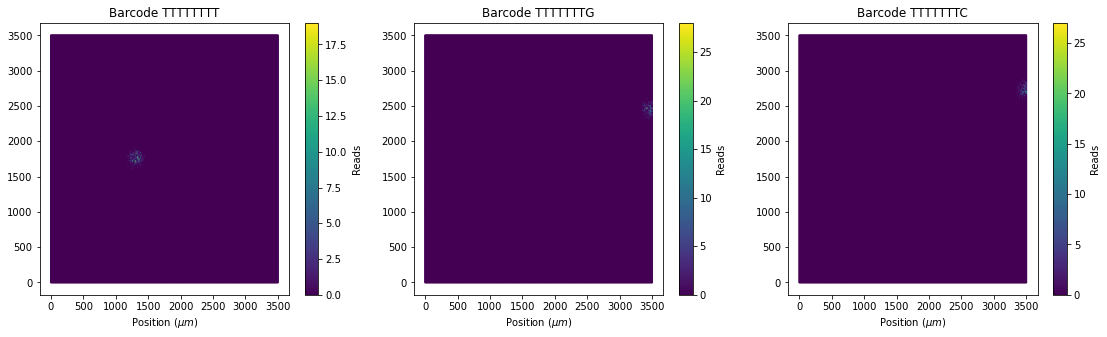

In [9]:
# Visualize reads from a few satellites
EDGE_LENGTH_UM = int(10*n)
STEP_UM = 500
steps = int(np.ceil(EDGE_LENGTH_UM/STEP_UM))

fig = plt.figure(figsize=(19,5))
for i in range(3):
    plt.subplot(1,3,i + 1)
    plt.title('Barcode {}'.format(overlap_dist.index[i]))
    plt.scatter(adata.obs.x, adata.obs.y, c=adata.X.A[:,i], s=1)
    plt.colorbar(label='Reads')
    plt.xticks(np.arange(0, (steps + 1)/steps, 1/steps), range(0, STEP_UM*steps + 1, STEP_UM))
    plt.yticks(np.arange(0, (steps + 1)/steps, 1/steps), range(0, STEP_UM*steps + 1, STEP_UM))
    plt.xlabel('Position ($\mu m$)')
plt.show()

## Supplemental Methods
In the supplement we show results for two additional scenarios - using e.Coli colonies to disperse satellite barcodes and the standard satellite dispersion with anisotropic diffusion. Below we show how to simulate data to reproduce those results. Note that simulating satellite dispersion from bacterial colonies introduces a new parameter of the proportion of the surface covered by bacterial colonies.

In [10]:
# Define parameters for the supplemental methods
PROP_COVERAGE = 0.9

### Bacterial Colonies as Satellites

We suggest several methods for dispersing satellite barcodes. The figures in the main text simulate satellite barcode generation through gel PCR, where we can potentially generate over 100,000 satellites which may overlap in space. In the supplement, we discuss an alternative generation method using e.Coli colonies. The e.Coli colonies introduce several challenges, including that they may have irregular shapes, we may only be able to generate tens of throusands per square centimeter, and they will not be able to overlap in space as they grow in a single layer.

Here we generate data for irregular e.Coli colonies on a dense, uniform grid to recreate the reconstructions shown in the supplement.

In [11]:
# Generate beads on a uniform grid
y, x = np.meshgrid(np.arange(0,n), np.arange(0,n))
y = y.flatten()
x = x.flatten()
bead_coords = np.array([x/max(x), y/max(y)]).T
beads_df = pd.DataFrame(data=bead_coords, columns=['x', 'y'])

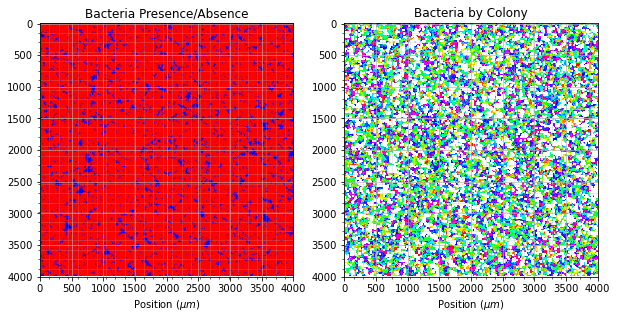

In [12]:
# Simulate and visualize the e.Coli colonies
colony_grid = simulate_bacterial.grow_colonies(int(n+2*3*SIGMA_BEAD), SATELLITES, SIGMA_BEAD, PROP_COVERAGE=PROP_COVERAGE)
simulate_bacterial.visualize_colonies(colony_grid, beadwidth=BEADWIDTH, step_size=500)

In [13]:
# Generate an anndata with satellite barcode counts stored in the read matrix
adata = simulate_bacterial.generate_reads(colony_grid=colony_grid, C=SATELLITES, n=n, 
                                          sigma_pixels=SIGMA_BEAD, reads_dist=reads_dist, 
                                          overlaps_dist=overlap_dist['Dist'], rpb='None',
                                          n_sigma_buffer = SIGMA_BUFFER, scaling = False, verbose=True)

adata.write_h5ad('../data/adata/{}_satellites={}_sigma={}_slideseq_irregular_colonies.h5ad'.format(SAMPLE, SATELLITES_PER_CM2, SIGMA_UM))

  0%|          | 32/99856 [00:00<05:20, 311.55it/s]

Generated beads.
Generating reads...


100%|██████████| 99856/99856 [06:16<00:00, 265.04it/s]


Generated expression matrix.
Generated anndata.
Adding metadata...
Finished read generation


... storing 'spatial_color' as categorical


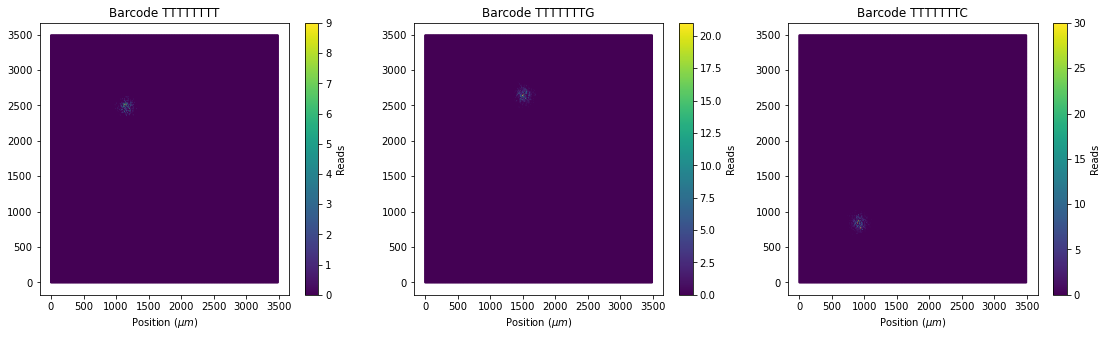

In [14]:
# Visualize reads from a few satellites
EDGE_LENGTH_UM = int(10*n)
STEP_UM = 500
steps = int(np.ceil(EDGE_LENGTH_UM/STEP_UM))

fig = plt.figure(figsize=(19,5))
for i in range(3):
    plt.subplot(1,3,i + 1)
    plt.title('Barcode {}'.format(overlap_dist.index[i]))
    plt.scatter(adata.obs.x, adata.obs.y, c=adata.X.A[:,i], s=1)
    plt.colorbar(label='Reads')
    plt.xticks(np.arange(0, n + 1, n/steps), range(0, STEP_UM*steps + 1, STEP_UM))
    plt.yticks(np.arange(0, n + 1, n/steps), range(0, STEP_UM*steps + 1, STEP_UM))
    plt.xlabel('Position ($\mu m$)')
plt.show()